# Figure 2a

In [1]:
library('ggplot2')
library('tidyverse')
library('stringr')
library('reshape2')
library('gaston')
library('data.table')
library('scales')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: Rcpp

Loading required package: RcppParallel


Attaching package: ‘RcppParallel’


The following object is masked from ‘package:Rcpp’:

    LdFlags


Gaston set number of threads to 4. Use setThreadOptions() to modify this.


Attaching package: ‘gaston’


The following object is masked from ‘package:stats’:

    sigma


The following objects are masked from ‘package:base’:

    cbind, rbind



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, me

In [2]:
# Get proper names of the phenotypes/allelotypes
options(repr.plot.width=25, repr.plot.height=34)
hla <- fread('../output/hla_complete.tsv', sep='\t', header=TRUE, stringsAsFactors = FALSE)
hla <- hla %>% filter(!is.na(BMA_posterior_mean)) %>% filter(BMA_posterior_prob >= 80) #

print(dim(hla))

bma_lit <- fread('../manuscript/hla_supp_1.tsv', sep='\t', header=TRUE, stringsAsFactors=FALSE) %>% select('allelotype','GBE_NAME','novel','nonadditive','URL')
hla <- hla %>% full_join(bma_lit)%>% mutate(GBE_NAME = str_replace_all(GBE_NAME, "_", " "))

print(dim(hla))

get_hclust_order_from_mat <- function(mat){
  mat_hclust <- (mat %>% dist() %>% hclust())
  sort_order <- mat_hclust$order
  keys <- mat %>% select(key) %>% pull()
  data.frame(
    key = keys[sort_order],
    order = 1:length(keys)
  )    
}

# Generate order
pheno_order <- hla %>% 
  rename(key = GBE_NAME) %>%
  dcast(key ~ allelotype, mean, value.var = 'add_BETA', fill=0) %>%
  get_hclust_order_from_mat() %>% rename(GBE_NAME = key, pheno_order = order) 

# Do the joins
hla_order <- hla %>% 
  inner_join(pheno_order, by='GBE_NAME') 

myplot <- ggplot(hla_order, aes(y = reorder(GBE_NAME, pheno_order), x = allelotype, fill = BMA_posterior_mean, size = novel, shape = ifelse(BMA_posterior_mean>0,"A","B"))) + 
geom_point(stroke=1, color="black") + scale_size_manual(values=c(4,8))  + 
theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1, size=20), axis.text.y = element_text(size=20), axis.title=element_text(size=30,face="bold"), legend.title = element_text(size=20), legend.text = element_text(size=20)) +
labs(x = "HLA Allelotype", y = "Global Biobank Engine Phenotype", size='Novel Finding') +
guides(size=guide_legend(override.aes=list(colour="turquoise4",shape=25))) + 
scale_shape_manual(guide=FALSE, values=c(24, 25)) + 
scale_fill_gradient2(low = "turquoise4", mid = "white", high = "orangered1", midpoint = 0, limits = c(-0.75, 0.75), oob=squish) 

[1] 178  37


Joining, by = c("allelotype", "GBE_NAME")



[1] 178  40


Warning message in dist(.):
“NAs introduced by coercion”
Warning message:
“Column `GBE_NAME` joining character vector and factor, coercing into character vector”


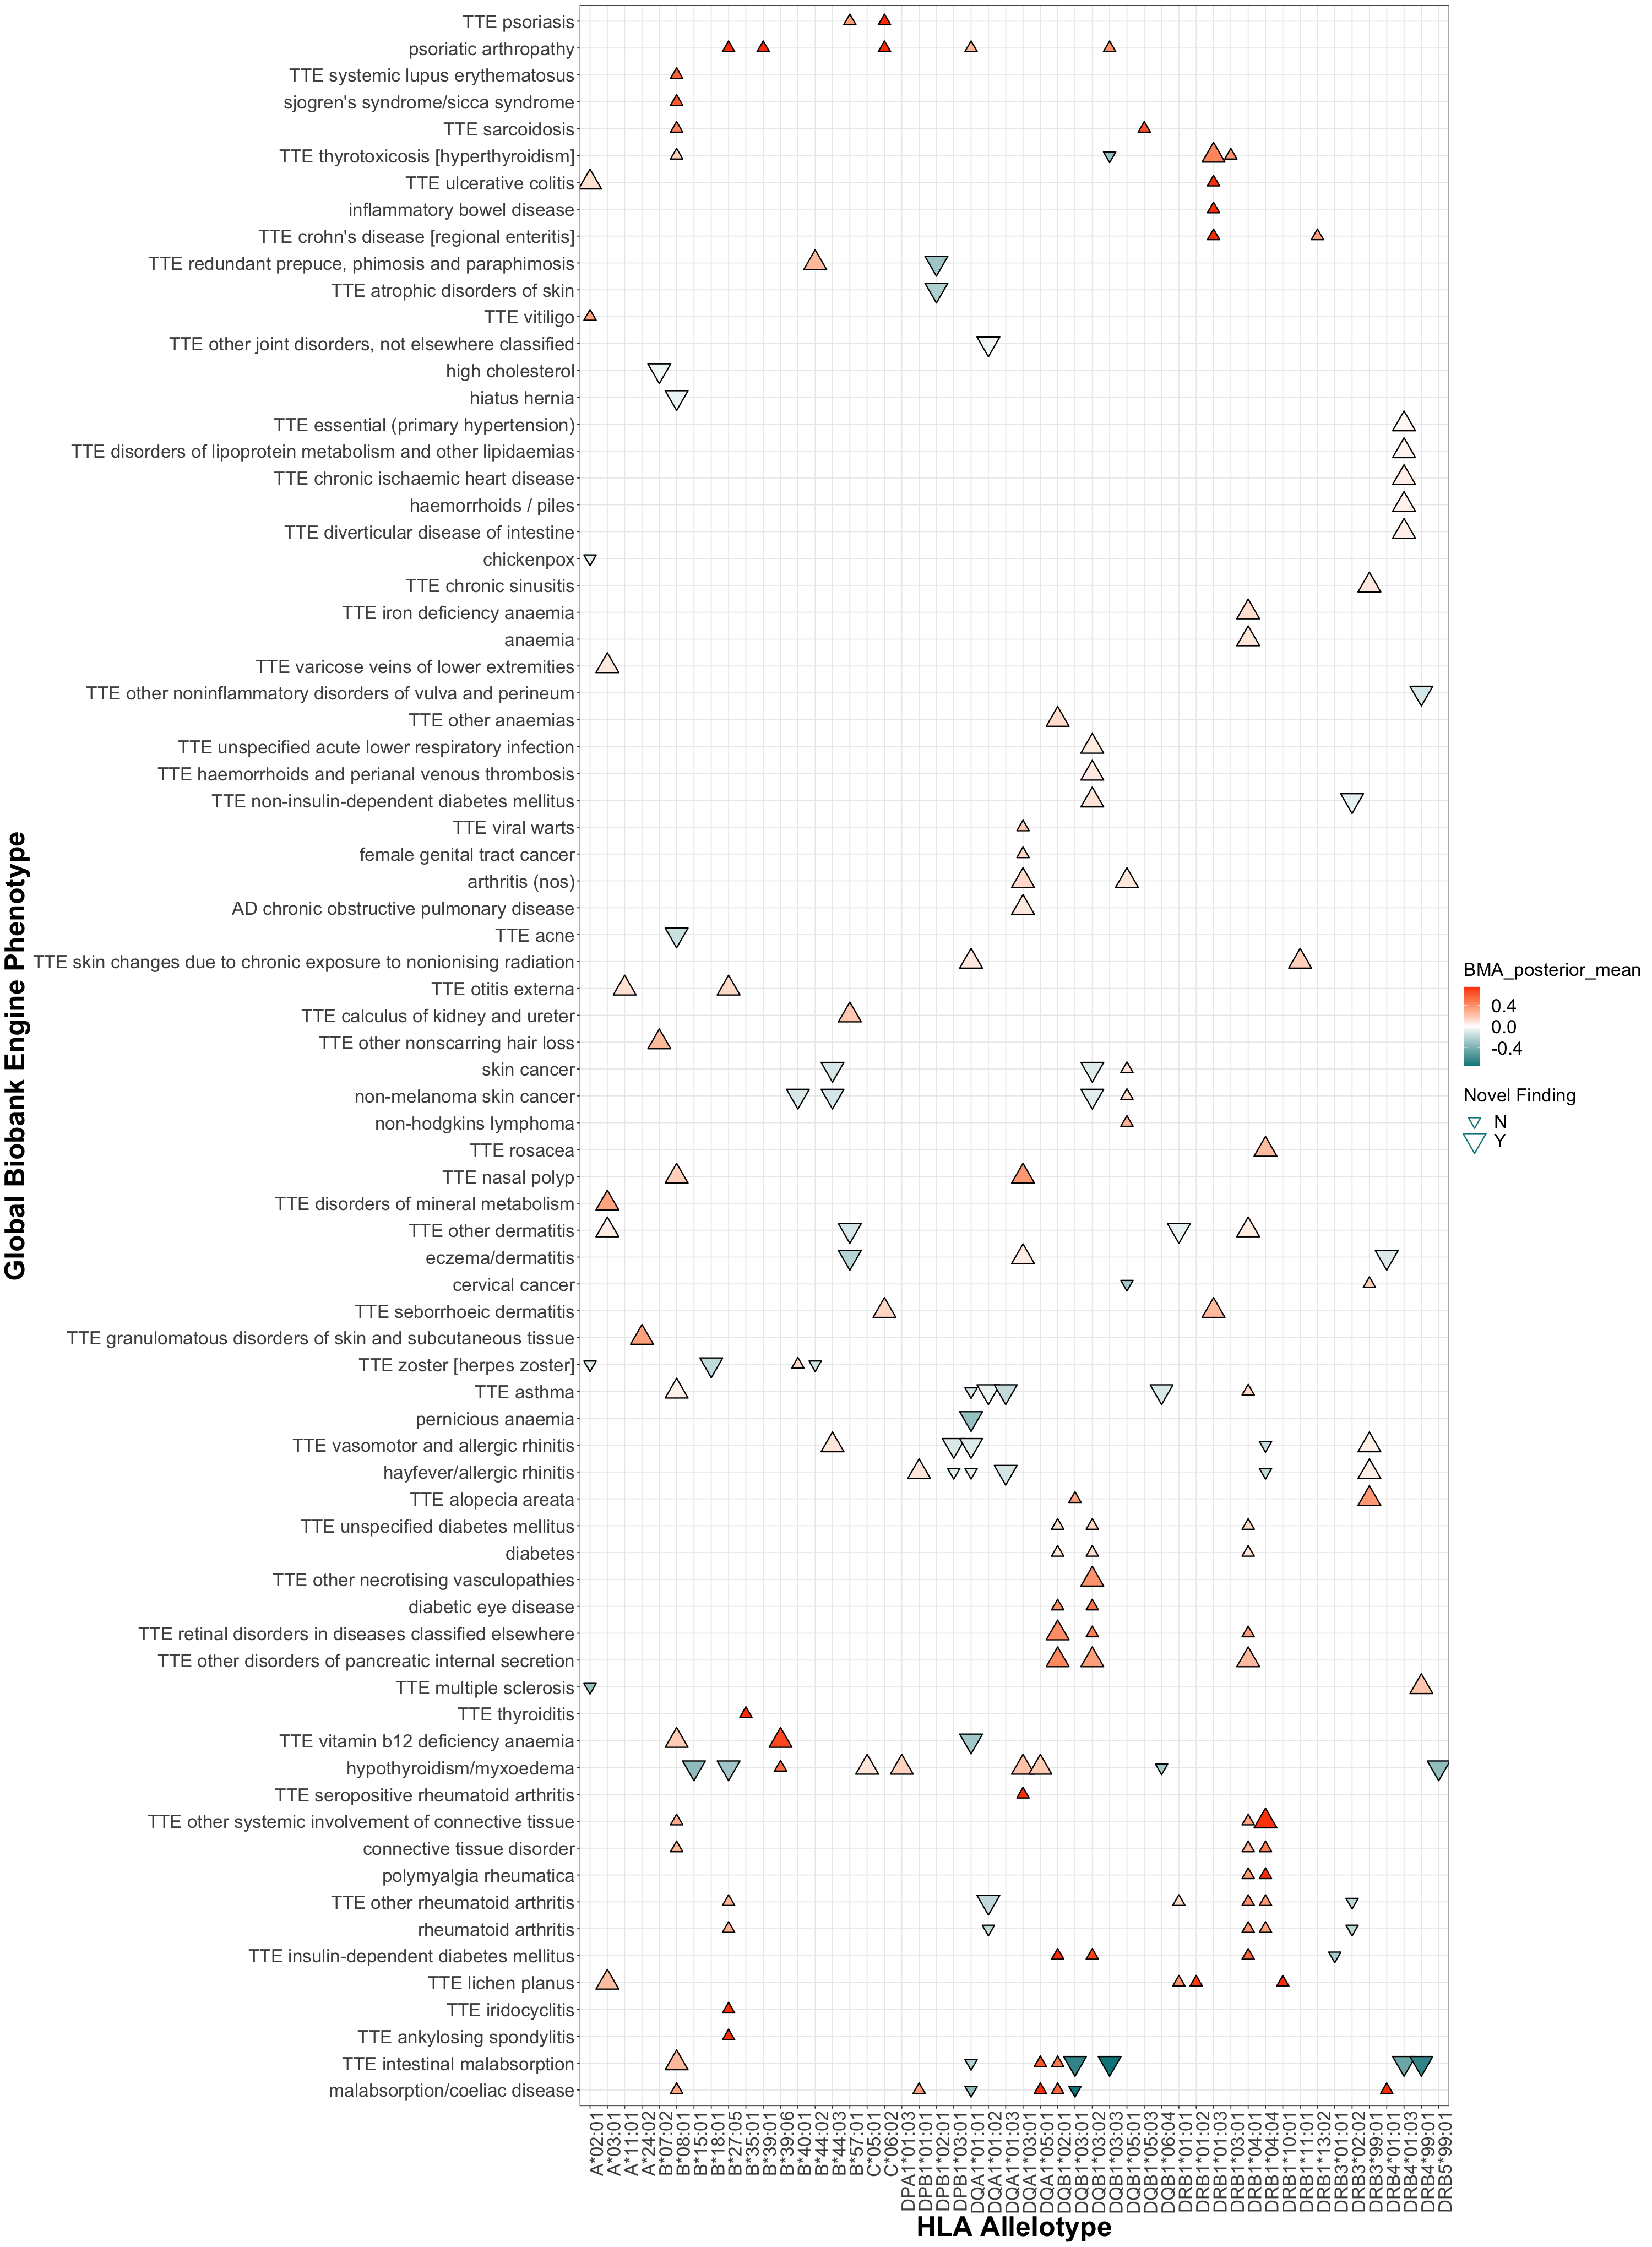

In [3]:
myplot

In [4]:
ggsave('../figures/fig2a.jpg',myplot, scale = 1,
  width = 25,
  height = 34,
  units ="in",
  dpi = 300)